In [ ]:
# Import necessary libraries for deep learning and data processing
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Download the potato disease dataset from Kaggle
path = kagglehub.dataset_download("hafiznouman786/potato-plant-diseases-data")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/potato-plant-diseases-data


In [ ]:
def load_dataset(data_path):
    """Load images and labels from the nested dataset directory structure"""
    images = []
    labels = []
    class_names = []

    # Navigate to PotatoPlants directory which contains the class folders
    potato_plants_path = os.path.join(data_path, 'PotatoPlants')

    if not os.path.exists(potato_plants_path):
        print(f"PotatoPlants directory not found at {potato_plants_path}")
        print("Available directories:", os.listdir(data_path))
        return np.array([]), np.array([]), []

    # Get class directories from PotatoPlants folder
    for class_dir in sorted(os.listdir(potato_plants_path)):
        class_path = os.path.join(potato_plants_path, class_dir)
        if os.path.isdir(class_path):
            class_names.append(class_dir)

    print(f"Found {len(class_names)} disease classes: {class_names}")

    # Load images from each class
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(potato_plants_path, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Loading {len(image_files)} images from {class_name}")

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            try:
                # Load and resize image to 200x200 pixels
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (200, 200))
                image = image.astype('float32') / 255.0

                images.append(image)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load the complete dataset
X, y, class_names = load_dataset(path)
print(f"Dataset loaded: {X.shape[0]} images of shape {X.shape[1:]}")
print(f"Classes: {class_names}")

# Display class distribution to understand the imbalance
class_counts = Counter(y)
print("\nClass distribution:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} images")

Found 3 disease classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Loading 1000 images from Potato___Early_blight
Loading 1000 images from Potato___Late_blight
Loading 152 images from Potato___healthy
Dataset loaded: 2152 images of shape (200, 200, 3)
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Class distribution:
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images


In [ ]:
def create_potato_disease_cnn(input_shape=(200, 200, 3), num_classes=3):
    """
    Create CNN architecture for potato disease classification
    Uses 3 convolutional blocks followed by dense layers for classification
    """

    # Input layer
    inputs = keras.Input(shape=input_shape, name='input_layer')

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_block1')(inputs)
    x = layers.MaxPooling2D((2, 2), name='maxpool_block1')(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_block2')(x)
    x = layers.MaxPooling2D((2, 2), name='maxpool_block2')(x)

    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_block3')(x)
    x = layers.MaxPooling2D((2, 2), name='maxpool_block3')(x)

    # Classification layers
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', name='dense_hidden')(x)
    x = layers.Dropout(0.7, name='dropout_regularization')(x)

    # Output layer for 3-class classification
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs, name='potato_disease_classifier')

    return model

# Initialize the model
model = create_potato_disease_cnn()

# Display model architecture
model.summary()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully")

Model: "potato_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block1 (Conv2D)          │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block1 (MaxPooling2D)   │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block2 (Conv2D)          │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block2 (MaxPooling2D)   │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_block3 (Conv2D)          │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_block3 (MaxPooling2D)   │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 512)            │    34,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_regularization          │ (None, 512)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,763,843 (132.61 MB)

 Trainable params: 34,763,843 (132.61 MB)

 Non-trainable params: 0 (0.00 B)

Model compiled successfully


In [ ]:
def create_augmentation_generators():
    """
    Create data augmentation generators for improving model generalization
    Uses conservative augmentation to maintain data quality
    """

    # Standard augmentation for majority classes
    standard_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.08,
        height_shift_range=0.08,
        horizontal_flip=True,
        zoom_range=0.08,
        brightness_range=[0.85, 1.15],
        fill_mode='nearest'
    )

    # Slightly more intensive augmentation for minority class
    intensive_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    return standard_datagen, intensive_datagen

# Create augmentation generators
standard_datagen, intensive_datagen = create_augmentation_generators()
print("Data augmentation generators created")

Data augmentation generators created


In [ ]:
def stratified_split_with_augmentation(X, y, class_names, test_size=0.1, val_size=0.1):
    """
    Split dataset using 80-10-10 strategy to maximize training data
    Particularly beneficial for the minority class (healthy potatoes)
    """

    print("Dataset splitting strategy (80-10-10):")
    print(f"Training: {(1-test_size-val_size)*100:.0f}% | Validation: {val_size*100:.0f}% | Testing: {test_size*100:.0f}%")

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Second split: separate training and validation sets
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Perform dataset splitting
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split_with_augmentation(X, y, class_names)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Dataset splitting strategy (80-10-10):
Training: 80% | Validation: 10% | Testing: 10%
Training set: 1720 images
Validation set: 216 images
Test set: 216 images


In [ ]:
def analyze_split_distribution(y_train, y_val, y_test, class_names):
    """Analyze class distribution across different splits"""

    print("\nDetailed split distribution:")

    splits = {'Training': y_train, 'Validation': y_val, 'Test': y_test}

    for split_name, split_labels in splits.items():
        print(f"\n{split_name} set:")
        unique, counts = np.unique(split_labels, return_counts=True)

        for class_idx, count in zip(unique, counts):
            percentage = (count / len(split_labels)) * 100
            print(f"  {class_names[class_idx]}: {count} images ({percentage:.1f}%)")

analyze_split_distribution(y_train, y_val, y_test, class_names)


Detailed split distribution:

Training set:
  Potato___Early_blight: 799 images (46.5%)
  Potato___Late_blight: 799 images (46.5%)
  Potato___healthy: 122 images (7.1%)

Validation set:
  Potato___Early_blight: 100 images (46.3%)
  Potato___Late_blight: 101 images (46.8%)
  Potato___healthy: 15 images (6.9%)

Test set:
  Potato___Early_blight: 101 images (46.8%)
  Potato___Late_blight: 100 images (46.3%)
  Potato___healthy: 15 images (6.9%)


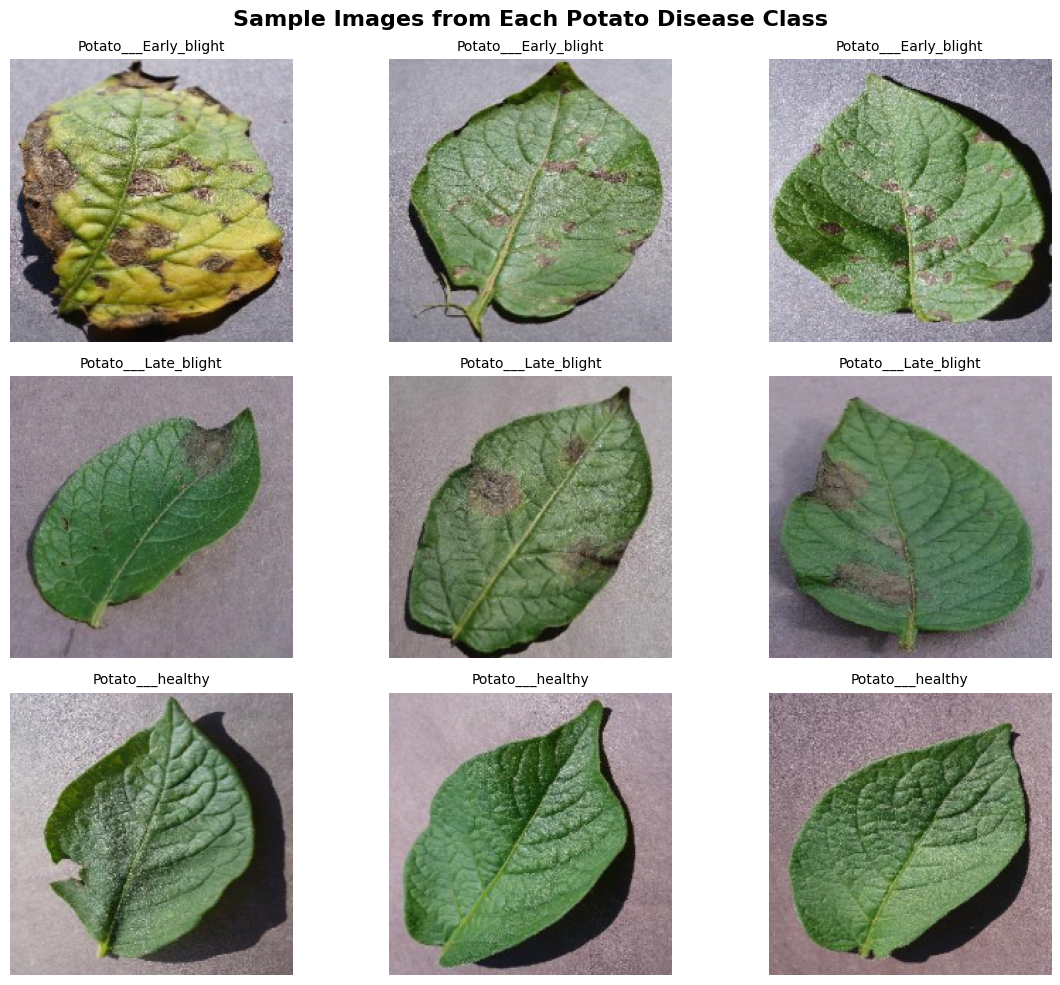

In [ ]:
def display_sample_images(X, y, class_names, samples_per_class=3):
    """Display sample images from each disease class"""

    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(12, 10))
    fig.suptitle('Sample Images from Each Potato Disease Class', fontsize=16, fontweight='bold')

    for class_idx, class_name in enumerate(class_names):
        # Get indices for current class
        class_indices = np.where(y == class_idx)[0]

        # Randomly select sample indices
        sample_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        for col, sample_idx in enumerate(sample_indices):
            ax = axes[class_idx, col]
            ax.imshow(X[sample_idx])
            ax.set_title(f'{class_name}', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from each class
display_sample_images(X, y, class_names)

In [ ]:
def detect_data_leakage(X_train, X_val, X_test, threshold=0.95):
    """
    Check for data leakage between training, validation, and test sets
    Uses image similarity analysis to detect potential issues
    """

    print("Performing data leakage analysis")

    def calculate_image_similarity(img1, img2):
        """Calculate correlation between two images"""
        img1_flat = img1.flatten()
        img2_flat = img2.flatten()

        correlation = np.corrcoef(img1_flat, img2_flat)[0, 1]
        return correlation if not np.isnan(correlation) else 0

    # Check for high similarities between splits
    train_val_similarities = []
    for i in range(min(100, len(X_train))):
        for j in range(min(100, len(X_val))):
            similarity = calculate_image_similarity(X_train[i], X_val[j])
            if similarity > threshold:
                train_val_similarities.append(similarity)

    train_test_similarities = []
    for i in range(min(100, len(X_train))):
        for j in range(min(100, len(X_test))):
            similarity = calculate_image_similarity(X_train[i], X_test[j])
            if similarity > threshold:
                train_test_similarities.append(similarity)

    val_test_similarities = []
    for i in range(min(100, len(X_val))):
        for j in range(min(100, len(X_test))):
            similarity = calculate_image_similarity(X_val[i], X_test[j])
            if similarity > threshold:
                val_test_similarities.append(similarity)

    print(f"High similarities found (threshold: {threshold}):")
    print(f"  Train-Validation: {len(train_val_similarities)}")
    print(f"  Train-Test: {len(train_test_similarities)}")
    print(f"  Validation-Test: {len(val_test_similarities)}")

    if len(train_val_similarities) == 0 and len(train_test_similarities) == 0 and len(val_test_similarities) == 0:
        print("No significant data leakage detected")
    else:
        print("Warning: Potential data leakage detected")

# Perform data leakage detection
detect_data_leakage(X_train, X_val, X_test)

Performing data leakage analysis
High similarities found (threshold: 0.95):
  Train-Validation: 0
  Train-Test: 0
  Validation-Test: 0
No significant data leakage detected


In [ ]:
def setup_training_callbacks():
    """Configure callbacks for optimal training"""

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        min_delta=0.01,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )

    # Learning rate reduction when training plateaus
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.5,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    )

    return [early_stopping, lr_reduction]

# Setup training callbacks
callbacks = setup_training_callbacks()

def prepare_naturally_balanced_data(X_train, y_train, class_names):
    """
    Apply natural augmentation without forcing perfect balance
    Uses conservative approach - only reasonable improvement for minority class
    """

    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    minority_class = unique_classes[np.argmin(class_counts)]
    minority_count = np.min(class_counts)

    # Natural augmentation - only moderate improvement (not forcing balance)
    natural_target = int(minority_count * 1.8)  # Just 80% increase, very conservative

    print("Natural class balancing approach:")
    print(f"Minority class: {class_names[minority_class]} ({minority_count} original images)")
    print(f"Natural augmentation target: {natural_target} images (conservative improvement)")

    # Keep original distribution for majority classes
    X_balanced = list(X_train)
    y_balanced = list(y_train)

    # Process each class
    for class_idx in unique_classes:
        class_count = class_counts[class_idx]
        if class_idx == minority_class:
            needed_samples = natural_target - class_count
            if needed_samples > 0:
                print(f"{class_names[class_idx]}: {class_count} original + {needed_samples} augmented = {natural_target} total")

                # Generate moderate augmented samples
                class_images = X_train[y_train == class_idx]
                augmented_images = []

                for _ in range(needed_samples):
                    random_idx = np.random.randint(0, len(class_images))
                    img = class_images[random_idx]

                    # Apply light augmentation
                    img_expanded = np.expand_dims(img, 0)
                    augmented = standard_datagen.flow(img_expanded, batch_size=1)
                    augmented_img = next(augmented)[0]

                    augmented_images.append(augmented_img)

                X_balanced.extend(augmented_images)
                y_balanced.extend([class_idx] * needed_samples)
            else:
                print(f"{class_names[class_idx]}: {class_count} images (no augmentation needed)")
        else:
            print(f"{class_names[class_idx]}: {class_count} images (preserved)")

    final_unique, final_counts = np.unique(y_balanced, return_counts=True)
    print(f"\nFinal training distribution after natural augmentation:")
    for class_idx, count in zip(final_unique, final_counts):
        percentage = (count / len(y_balanced)) * 100
        print(f"  {class_names[class_idx]}: {count} images ({percentage:.1f}%)")

    print(f"Total training images: {len(X_balanced)}")

    return np.array(X_balanced), np.array(y_balanced)

# Apply natural augmentation (conservative approach)
X_train_natural, y_train_natural = prepare_naturally_balanced_data(X_train, y_train, class_names)

# Calculate optimal class weights for remaining imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_natural),
    y=y_train_natural
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\nOptimal class weights calculated:")
for class_idx, weight in class_weight_dict.items():
    print(f"  {class_names[class_idx]}: {weight:.2f}")



Natural class balancing approach:
Minority class: Potato___healthy (122 original images)
Natural augmentation target: 219 images (conservative improvement)
Potato___Early_blight: 799 images (preserved)
Potato___Late_blight: 799 images (preserved)
Potato___healthy: 122 original + 97 augmented = 219 total

Final training distribution after natural augmentation:
  Potato___Early_blight: 799 images (44.0%)
  Potato___Late_blight: 799 images (44.0%)
  Potato___healthy: 219 images (12.1%)
Total training images: 1817

Optimal class weights calculated:
  Potato___Early_blight: 0.76
  Potato___Late_blight: 0.76
  Potato___healthy: 2.77


In [ ]:
print("Starting model training with hybrid approach")

# Train the model with natural augmentation + class weights
history = model.fit(
    X_train_natural, y_train_natural,  # Naturally augmented data
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,  # Handle remaining imbalance
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

# Analyze training completion
final_epoch = len(history.history['accuracy'])
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
train_val_gap = final_train_acc - final_val_acc

print(f"\nTraining completed at epoch {final_epoch}")
if final_epoch < 20:
    print("Early stopping activated successfully")

print(f"Final train-validation gap: {train_val_gap:.3f} ({train_val_gap*100:.1f}%)")
print("Hybrid approach: Natural augmentation + Class weights used")

Starting model training with hybrid approach
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5025 - loss: 1.3686 - val_accuracy: 0.7083 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.7968 - loss: 0.4711 - val_accuracy: 0.8889 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.8828 - loss: 0.2568 - val_accuracy: 0.7176 - val_loss: 0.5109 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8793 - loss: 0.2720 - val_accuracy: 0.9537 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9264 - loss: 0.2052 - val_accuracy: 0.9398 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9253 - loss: 0.1749
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
57/57 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step -

Model Evaluation Results
Test Accuracy: 0.9306 (93.06%)

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight     0.9000    0.9802    0.9384       101
 Potato___Late_blight     0.9775    0.8700    0.9206       100
     Potato___healthy     0.8824    1.0000    0.9375        15

             accuracy                         0.9306       216
            macro avg     0.9200    0.9501    0.9322       216
         weighted avg     0.9347    0.9306    0.9301       216



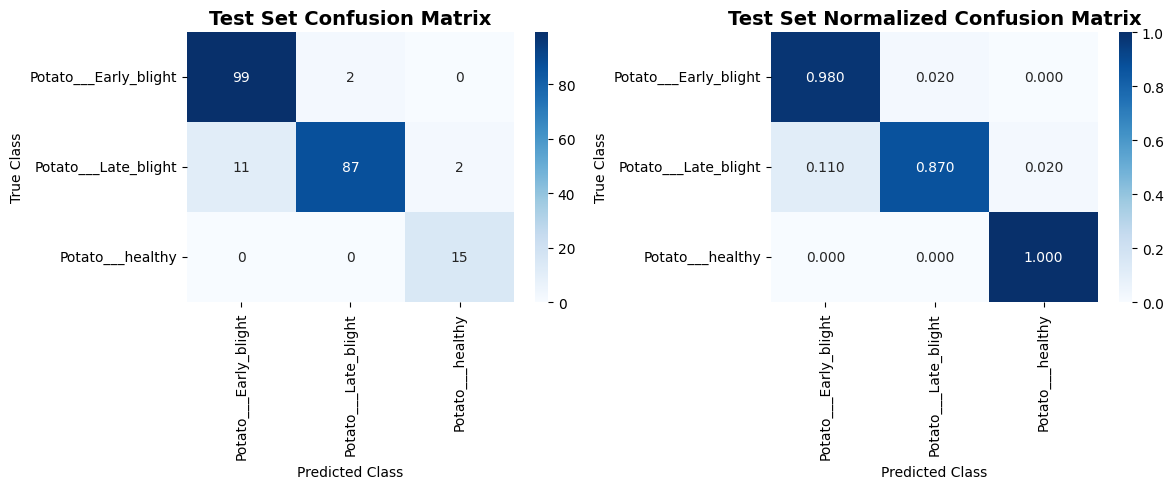

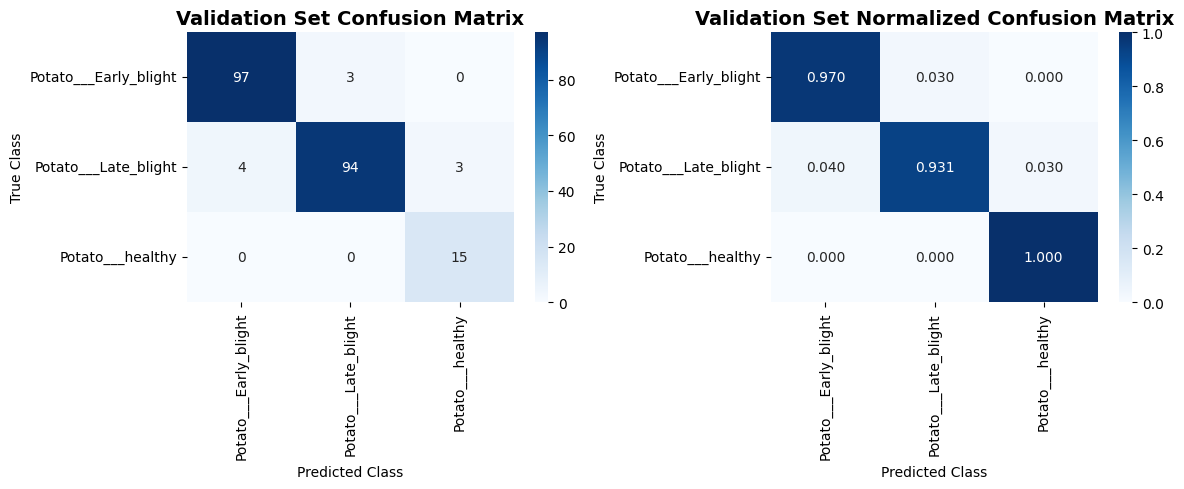


Per-Class Performance on Test Set:
  Potato___Early_blight: 0.9802 accuracy on 101 samples
  Potato___Late_blight: 0.8700 accuracy on 100 samples
  Potato___healthy: 1.0000 accuracy on 15 samples


In [ ]:
def comprehensive_model_evaluation(model, X_test, y_test, class_names, history):
    """
    Evaluate model performance using multiple metrics and visualizations
    """

    # Generate predictions for test set
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate test accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print("Model Evaluation Results")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    # Confusion matrix visualization for test set
    cm_test = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 5))

    # Original confusion matrix for test set
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    # Normalized confusion matrix for test set
    plt.subplot(1, 2, 2)
    cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_test_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Set Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    plt.tight_layout()
    plt.show()

    # Confusion matrix visualization for validation set
    y_val_pred_proba = model.predict(X_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_proba, axis=1)
    cm_val = confusion_matrix(y_val, y_val_pred)

    plt.figure(figsize=(12, 5))

    # Original confusion matrix for validation set
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Validation Set Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    # Normalized confusion matrix for validation set
    plt.subplot(1, 2, 2)
    cm_val_normalized = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_val_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Validation Set Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    plt.tight_layout()
    plt.show()


    # Per-class performance analysis
    print("\nPer-Class Performance on Test Set:")
    for i, class_name in enumerate(class_names):
        class_mask = y_test == i
        if np.sum(class_mask) > 0:
            class_accuracy = accuracy_score(y_test[class_mask], y_pred[class_mask])
            class_samples = np.sum(class_mask)
            print(f"  {class_name}: {class_accuracy:.4f} accuracy on {class_samples} samples")

    return accuracy, y_pred, y_pred_proba

# Evaluate the model
test_accuracy, predictions, prediction_probabilities = comprehensive_model_evaluation(
    model, X_test, y_test, class_names, history
)

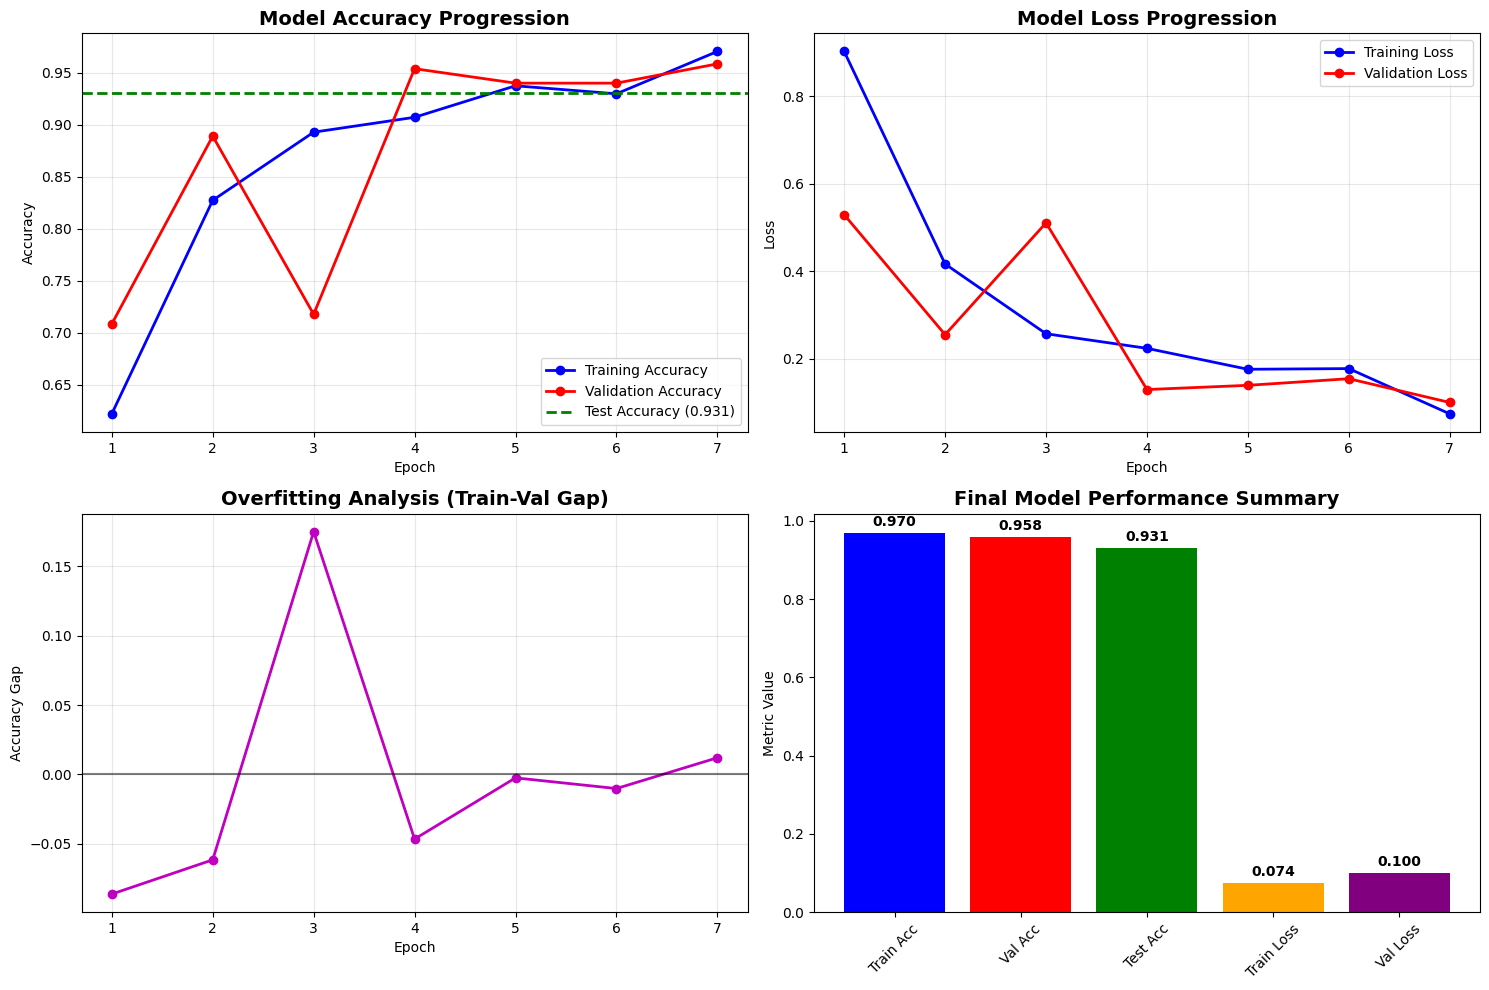

TRAINING PERFORMANCE SUMMARY
Total training epochs: 7
Best validation accuracy: 0.9583 (epoch 7)
Final training accuracy: 0.9703
Final validation accuracy: 0.9583
Final test accuracy: 0.9306
Overfitting indicator (final train-val gap): 0.0119


In [ ]:
# Training History Visualization and Model Insights

def visualize_training_insights(history, test_accuracy):
    """
    Create comprehensive visualizations of training process and model behavior
    Provides insights into convergence, overfitting, and optimization effectiveness
    """

    # Extract training history
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    # Create comprehensive training visualization
    plt.figure(figsize=(15, 10))

    # Training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy', linewidth=2)
    plt.axhline(y=test_accuracy, color='green', linestyle='--',
                label=f'Test Accuracy ({test_accuracy:.3f})', linewidth=2)
    plt.title('Model Accuracy Progression', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss Progression', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning curve analysis
    plt.subplot(2, 2, 3)
    gap = np.array(train_acc) - np.array(val_acc)
    plt.plot(epochs, gap, 'mo-', linewidth=2)
    plt.title('Overfitting Analysis (Train-Val Gap)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Gap')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3)

    # Final performance summary
    plt.subplot(2, 2, 4)
    final_metrics = {
        'Train Acc': train_acc[-1],
        'Val Acc': val_acc[-1],
        'Test Acc': test_accuracy,
        'Train Loss': train_loss[-1],
        'Val Loss': val_loss[-1]
    }

    bars = plt.bar(range(len(final_metrics)), list(final_metrics.values()),
                   color=['blue', 'red', 'green', 'orange', 'purple'])
    plt.title('Final Model Performance Summary', fontsize=14, fontweight='bold')
    plt.xticks(range(len(final_metrics)), list(final_metrics.keys()), rotation=45)
    plt.ylabel('Metric Value')

    # Add value labels on bars
    for bar, value in zip(bars, final_metrics.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Training summary statistics
    print("TRAINING PERFORMANCE SUMMARY")
    print(f"Total training epochs: {len(epochs)}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (epoch {np.argmax(val_acc)+1})")
    print(f"Final training accuracy: {train_acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final test accuracy: {test_accuracy:.4f}")
    print(f"Overfitting indicator (final train-val gap): {train_acc[-1] - val_acc[-1]:.4f}")

# Visualize training insights and performance
visualize_training_insights(history, test_accuracy)